In [1]:
# to avoid to restart kernel when external modules are modified
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import cv2
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../.")

from image_to_melody.img_utils import (
    get_k_representatives, get_representative_pixels
)

### Read image and get the representative pixels

In [35]:
base_path = "../sample_images"
sample_img_filename = "002_pilares_de_la_creacion.png"
sample_img_filename = "007_flowers_field.jpg"
sample_img_filename = "004_aurora_boreal.jpg"
sample_img_filename = "003_starry_night.jpg"
sample_img_filename = "006_fractal.jpg"
sample_img_filename = "008_atardecer.jpg"

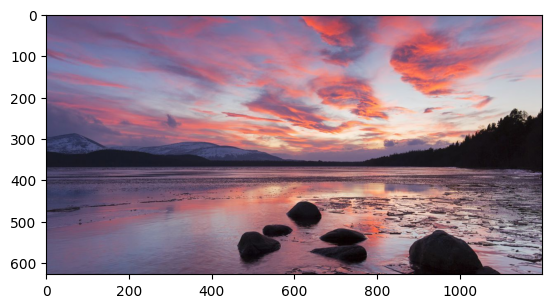

In [36]:
img = cv2.imread(filename=f"{base_path}/{sample_img_filename}")
color_image = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)

plt.imshow(color_image)
plt.show()

In [37]:
number_slices = 25
k = 4

representative_pixels = get_representative_pixels(
    color_image, number_slices, k
)

In [38]:
num_pixels = number_slices * k

df_repixels = pd.DataFrame(
    representative_pixels[:num_pixels], columns=["red", "green", "blue"]
)
df_repixels.shape

(100, 3)

In [39]:
df_repixels.describe()

,red,green,blue
count,100.000000,100.000000,100.000000
mean,128.080173,101.716781,116.115562
std,66.675631,54.353574,52.556430
min,23.517146,18.085112,21.411376
25%,65.194061,60.879783,85.205190
50%,134.504737,104.415334,124.680613
75%,188.318130,135.845006,152.028334
max,232.092105,206.350411,201.525880


array([[<Axes: title={'center': 'red'}>,
        <Axes: title={'center': 'green'}>],
       [<Axes: title={'center': 'blue'}>, <Axes: >]], dtype=object)

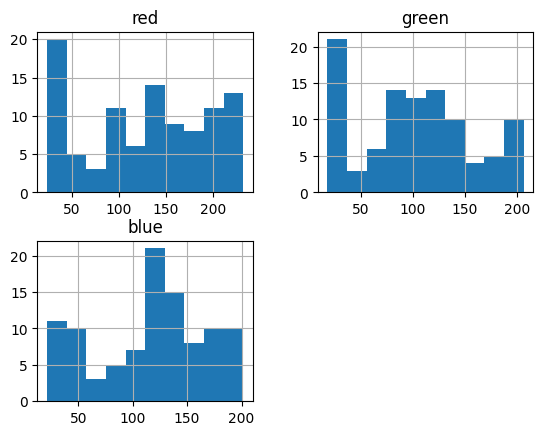

In [40]:
df_repixels[["red", "green", "blue"]].hist()

### Generate tracks

In [13]:
from mido import Message, MidiFile, MidiTrack, MetaMessage

In [14]:
class Track:
    def __init__(
        self,
        instrument_midi_number: int,
        notes: list,
        channel: int,
        note_duration: int = 200,
        velocity: int = 100,
    ):
        self.instrument_midi_number = instrument_midi_number
        self.track = MidiTrack()
        self.track.append(Message(
            "program_change", program=instrument_midi_number, channel=channel, time=0)
        )
        self.notes = notes
        self.channel = channel
        self.thresholds = np.linspace(start=0, stop=255, num=len(notes))
        self.note_duration = note_duration
        self.velocity = velocity

    def add_note(self, rgb_value: int):
        note = self.notes[0]

        # optimize this part
        for idx, threshold in enumerate(self.thresholds):
            if rgb_value < threshold:
                note = self.notes[idx]
                break

        self.track.append(
            Message("note_on", channel=self.channel, note=note, velocity=self.velocity, time=0)
        )
        self.track.append(
            Message(
                "note_off", channel=self.channel, note=note, velocity=self.velocity, time=self.note_duration
            )
        )

    def finish(self):
        self.track.append(MetaMessage("end_of_track", time=0))


### Synthesize

In [15]:
from midi2audio import FluidSynth

SAMPLE_RATE = 44100
# Replace this with the path to your SoundFont file
soundfont_path = (
    "/home/david/Descargas/GeneralUser_GS_1.471/GeneralUser GS 1.471/GeneralUser GS v1.471.sf2"
)

def synthesize(midi_file_path: str, output_path: str, sample_rate: int):
    fs = FluidSynth(sound_font=soundfont_path, sample_rate=sample_rate)

    fs.midi_to_audio(midi_file_path, output_path)

### Chords

In [9]:
# Major Chords
A_MAJOR_CHORD = [57, 61, 64] # A, C#, E
B_MAJOR_CHORD = [59, 63, 66] # B, D#, F#
C_MAJOR_CHORD = [60, 64, 67] # C, E, G 
E_MAJOR_CHORD = [64, 68, 71] # E, G#, B
G_MAJOR_CHORD = [55, 59, 62] # G, B, D
F_MAJOR_CHORD = [65, 69, 72] # F, A, C 

# Minor Chords
A_MINOR = [57, 60, 64] # A, C, E
B_MINOR = [59, 62, 66] # B, D, F
D_MINOR = [62, 65, 69] # D, F, A
E_MINOR = [64, 67, 71] # E, G, B
F_MINOR = [65, 58, 72] # F, #G, C

# MIDI note numbers for the root notes, recommend for bass
C_MAJOR_ROOT = [48]  # C
F_MAJOR_ROOT = [53]  # F
G_MAJOR_ROOT = [55]  # G

### Group #1 Electric guitar, and Synth

In [69]:
electric_guitar_synth_midi_file = "electric_guitar_synth.mid"
electric_guitar_synth_audio_file = "electric_guitar_synth.wav"

In [90]:
# Create a new MIDI file and tracks
mid = MidiFile()

note_duration = 500

elec_guitar_track = Track(
    instrument_midi_number=27,
    notes=G_MAJOR_CHORD + C_MAJOR_CHORD,
    channel=0,
    note_duration=note_duration,
    velocity=100,
)

synth_pad_track = Track(
    instrument_midi_number=93,
    notes=F_MAJOR_CHORD,
    channel=1,
    note_duration=note_duration,
    velocity=64
)

mid.tracks.append(elec_guitar_track.track)
mid.tracks.append(synth_pad_track.track)

for idx, row in df_repixels.iterrows():
    elec_guitar_track.add_note(rgb_value=row["red"])
    rgb_avg = (row["red"] + row["green"] + row["blue"]) // 3
    synth_pad_track.add_note(rgb_value=rgb_avg)

elec_guitar_track.finish()
synth_pad_track.finish()

In [ ]:
mid.save(electric_guitar_synth_midi_file)

synthesize(
    electric_guitar_synth_midi_file, electric_guitar_synth_audio_file, sample_rate=SAMPLE_RATE
)

ipd.Audio(data=electric_guitar_synth_audio_file, rate=SAMPLE_RATE, autoplay=True)

### Group #2 Acustic Guitar, piano and bass

In [103]:
piano_guitar_bass_midi_file = "piano_guitar_bass.mid"
piano_guitar_bass_audio_file = "piano_guitar_bass.wav"

In [104]:
# Create a new MIDI file and tracks
mid = MidiFile()

note_duration = 500

piano_track = Track(
    instrument_midi_number=0, notes=C_MAJOR_CHORD, channel=0, note_duration=note_duration
)
guitar_track = Track(
    instrument_midi_number=24,
    notes=G_MAJOR_CHORD,
    channel=1,
    note_duration=note_duration,
    velocity=74,
)

bass_notes = C_MAJOR_ROOT + F_MAJOR_ROOT + G_MAJOR_ROOT
bass_track = Track(
    instrument_midi_number=32,
    notes=bass_notes,
    channel=2,
    note_duration=note_duration,
    velocity=64
)

mid.tracks.append(piano_track.track)
mid.tracks.append(guitar_track.track)
mid.tracks.append(bass_track.track)

for idx, row in df_repixels.iterrows():
    guitar_track.add_note(rgb_value=row["red"])
    piano_track.add_note(rgb_value=row["green"])
    bass_track.add_note(rgb_value=row["blue"])

piano_track.finish()
guitar_track.finish()
bass_track.finish()

In [ ]:
mid.save(piano_guitar_bass_midi_file)

synthesize(
    piano_guitar_bass_midi_file, piano_guitar_bass_audio_file, sample_rate=SAMPLE_RATE
)

ipd.Audio(data=piano_guitar_bass_audio_file, rate=SAMPLE_RATE, autoplay=True)

### 

### Group #3 Viola, trombone and banjo

In [13]:
viola_trombone_banjo_midi_file = "viola_trombone_banjo.mid"
viola_trombone_banjo_audio_file = "viola_trombone_banjo.wav"

In [14]:
mid = MidiFile()

note_duration = 500

viola_notes = list(set(B_MAJOR_CHORD + C_MAJOR_CHORD))
viola_notes.sort()
print("viola notes", viola_notes)

viola_track = Track(
    instrument_midi_number=41, notes=E_MAJOR_CHORD, channel=0, note_duration=note_duration
)
trombone_track = Track(
    instrument_midi_number=57,
    notes=C_MAJOR_CHORD,
    channel=1,
    note_duration=note_duration,
    velocity=64,
)

banjo_track = Track(
    instrument_midi_number=105,
    notes=E_MAJOR_CHORD,
    channel=2,
    note_duration=note_duration,
    velocity=64
)

mid.tracks.append(viola_track.track)
mid.tracks.append(trombone_track.track)
mid.tracks.append(banjo_track.track)

for idx, row in df_repixels.iterrows():
    trombone_track.add_note(rgb_value=row["red"])
    viola_track.add_note(rgb_value=row["green"])
    banjo_track.add_note(rgb_value=row["blue"])

trombone_track.finish()
viola_track.finish()
banjo_track.finish()

viola notes [59, 60, 63, 64, 66, 67]


In [ ]:
mid.save(viola_trombone_banjo_midi_file)

synthesize(
    viola_trombone_banjo_midi_file, viola_trombone_banjo_audio_file, sample_rate=SAMPLE_RATE
)

ipd.Audio(data=viola_trombone_banjo_audio_file, rate=SAMPLE_RATE, autoplay=True)

### Group #4 Violin, clarinet and piano

In [10]:
violin_clarinet_piano_midi_file = "violin_clarinet_piano.mid"
violin_clarinet_piano_audio_file = "violin_clarinet_piano.wav"

In [18]:
mid_4 = MidiFile()

note_duration = 500

# violin_notes = list(set(B_MAJOR_CHORD + C_MAJOR_CHORD))
# viola_notes.sort()
# print("viola notes", viola_notes)

violin_track = Track(
    instrument_midi_number=40, notes=B_MINOR, channel=0, note_duration=note_duration
)

clarinet_notes = list(set(A_MINOR + F_MINOR))
clarinet_notes.sort()

clarinet_track = Track(
    instrument_midi_number=71,
    notes=clarinet_notes,
    channel=1,
    note_duration=note_duration,
    velocity=60,
)

piano_track = Track(
    instrument_midi_number=3,
    notes=C_MAJOR_CHORD,
    channel=2,
    note_duration=note_duration,
    velocity=64
)

mid_4.tracks.append(violin_track.track)
mid_4.tracks.append(clarinet_track.track)
mid_4.tracks.append(piano_track.track)

for idx, row in df_repixels.iterrows():
    piano_track.add_note(rgb_value=row["red"])
    clarinet_track.add_note(rgb_value=row["green"])
    violin_track.add_note(rgb_value=row["blue"])

violin_track.finish()
clarinet_track.finish()
piano_track.finish()

In [ ]:
mid_4.save(violin_clarinet_piano_midi_file)

synthesize(
    violin_clarinet_piano_midi_file, violin_clarinet_piano_audio_file, sample_rate=SAMPLE_RATE
)

ipd.Audio(data=violin_clarinet_piano_audio_file, rate=SAMPLE_RATE, autoplay=True)

### Group #5 Synth FX 4 (atmosphere), Ethnic (koto) and guitar electric

In [21]:
synth_ethnic_guitar_electric_midi_file = "synth_ethnic_guitar_electric.mid"
synth_ethnic_guitar_electric_audio_file = "synth_ethnic_guitar_electric.wav"

In [30]:
mid_5 = MidiFile()

note_duration = 500

synth_track = Track(
    instrument_midi_number=99, notes=E_MINOR, channel=0, note_duration=note_duration
)

ethnic_notes = list(set(B_MINOR + D_MINOR))
ethnic_notes.sort()

ethnic_track = Track(
    instrument_midi_number=107,
    notes=ethnic_notes,
    channel=1,
    note_duration=note_duration,
    velocity=64,
)

electric_guitar_track = Track(
    instrument_midi_number=26,
    notes=E_MAJOR_CHORD,
    channel=2,
    note_duration=note_duration,
    velocity=64
)

mid_5.tracks.append(synth_track.track)
mid_5.tracks.append(ethnic_track.track)
mid_5.tracks.append(electric_guitar_track.track)

for idx, row in df_repixels.iterrows():
    electric_guitar_track.add_note(rgb_value=row["red"])
    ethnic_track.add_note(rgb_value=row["green"])
    synth_track.add_note(rgb_value=row["blue"])

synth_track.finish()
ethnic_track.finish()
electric_guitar_track.finish()

In [ ]:
mid_5.save(synth_ethnic_guitar_electric_midi_file)

synthesize(
    synth_ethnic_guitar_electric_midi_file, synth_ethnic_guitar_electric_audio_file, sample_rate=SAMPLE_RATE
)

ipd.Audio(data=synth_ethnic_guitar_electric_audio_file, rate=SAMPLE_RATE, autoplay=True)

### Group #6 Harp, flute and choir



In [32]:
harp_flute_choir_midi_file = "harp_flute_choir.mid"
harp_flute_choir_audio_file = "harp_flute_choir.wav"

In [41]:
mid_6 = MidiFile()

note_duration = 500

harp_track = Track(
    instrument_midi_number=46, notes=G_MAJOR_CHORD, channel=0, note_duration=note_duration
)

flute_notes = list(set(C_MAJOR_CHORD + G_MAJOR_CHORD))
flute_notes.sort()

flute_track = Track(
    instrument_midi_number=73,
    notes=flute_notes,
    channel=1,
    note_duration=note_duration,
    velocity=64,
)

choir_track = Track(
    instrument_midi_number=52,
    notes=G_MAJOR_CHORD,
    channel=2,
    note_duration=note_duration,
    velocity=60
)

mid_6.tracks.append(harp_track.track)
mid_6.tracks.append(flute_track.track)
mid_6.tracks.append(choir_track.track)

for idx, row in df_repixels.iterrows():
    harp_track.add_note(rgb_value=row["red"])
    flute_track.add_note(rgb_value=row["green"])
    choir_track.add_note(rgb_value=row["blue"])

harp_track.finish()
flute_track.finish()
choir_track.finish()

In [ ]:
mid_6.save(harp_flute_choir_midi_file)

synthesize(
    harp_flute_choir_midi_file, harp_flute_choir_audio_file, sample_rate=SAMPLE_RATE
)

ipd.Audio(data=harp_flute_choir_audio_file, rate=SAMPLE_RATE, autoplay=True)

### Group #7 Trumpet and drum

In [43]:
trumpet_drum_midi_file = "trumpet_drum.mid"
trumpet_drum_audio_file = "trumpet_drum.wav"

In [54]:
mid_7 = MidiFile()

note_duration = 500

trumpet_notes = list(set(C_MAJOR_CHORD + E_MAJOR_CHORD))
trumpet_notes.sort()

trumpet_track = Track(
    instrument_midi_number=56,
    notes=trumpet_notes,
    channel=0,
    note_duration=note_duration,
    velocity=84
)

drum_notes = list(set(E_MAJOR_CHORD + F_MAJOR_CHORD))
drum_notes.sort()

drum_track = Track(
    instrument_midi_number=117,
    notes=drum_notes,
    channel=1,
    note_duration=note_duration,
    velocity=84,
)

mid_7.tracks.append(trumpet_track.track)
mid_7.tracks.append(drum_track.track)

for idx, row in df_repixels.iterrows():
    trumpet_track.add_note(rgb_value=row["red"])
    rgb_avg = (row["red"] + row["green"] + row["blue"]) // 3
    drum_track.add_note(rgb_value=rgb_avg)

trumpet_track.finish()
drum_track.finish()

In [ ]:
mid_7.save(trumpet_drum_midi_file)

synthesize(
    trumpet_drum_midi_file, trumpet_drum_audio_file, sample_rate=SAMPLE_RATE
)

ipd.Audio(data=trumpet_drum_audio_file, rate=SAMPLE_RATE, autoplay=True)

### Effects with Pedalboard

In [89]:
from pedalboard import (
    Pedalboard,
    Chorus,
    LadderFilter,
    Gain,
    Reverb,
    Delay,
    Phaser,
    Compressor,
    Limiter,
    HighpassFilter,
    PitchShift
)
from pedalboard.io import AudioFile

In [90]:
# Make a Pedalboard object, containing multiple audio plugins:
board = Pedalboard([
    Chorus(depth=0.15),
    Delay(delay_seconds=0.1),
    Reverb(room_size=0.5)
])

audio_examples = [
    audio_path
]

for audio_example_path in audio_examples:
    with AudioFile(audio_example_path) as f:
        new_path = audio_example_path.replace(".wav", "_effected.wav")
        with AudioFile(new_path, "w", f.samplerate, f.num_channels) as o:
            # Read one second of audio at a time, until the file is empty:
            while f.tell() < f.frames:
                chunk = f.read(int(f.samplerate))

                # Run the audio through our pedalboard:
                effected = board(chunk, f.samplerate, reset=False)

                # Write the output to our output file:
                o.write(effected)

ipd.Audio(new_path) # load a NumPy array as audio

### Receta

- [LISTO] Combinación piano y guitarra
- [LISTO] Más ideas: https://medium.com/@stevehiehn/how-to-generate-music-with-python-the-basics-62e8ea9b99a5
- [LISTO] Más ideas: https://youtu.be/aOsET8KapQQ -> Usan Pyo
- [LISTO] Re-iterar combiación piano y guitarra
- [ ] Combinación violín y flauta
- [ ] Combinación timpre y bombo
- [ ] Combinación sintetizador y batería electrónica
- [ ] Uso de instrumentos solos, probando diferentes rangos de frequencias.
- [ ] Implementar exp_2 